In [1]:
import anndata as ad
import scanpy as sc
import scglue
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os

In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [3]:
def load_adata(int_type):
    print("loading data..")
 
    if int_type == 'full_integration':
        rna = ad.read_h5ad("../pp_harm_data/rna-pp-harm-sub.h5ad")
        adt = ad.read_h5ad("../pp_harm_data/adt-pp-harm-sub.h5ad")
        cytof = ad.read_h5ad("../pp_harm_data/cytof-pp-harm-sub.h5ad")
        facs = ad.read_h5ad("../pp_harm_data/facs-pp-harm-sub.h5ad")
            
        adt.var.index = adt.var.index + '_adt'
        cytof.var.index = cytof.var.index + '_cytof'
        facs.var.index = facs.var.index + '_facs'
                
        return rna, adt, cytof, facs
    else:
        rna = ad.read_h5ad("../pp_harm_data/rna-pp-harm-sub.h5ad")
        adt = ad.read_h5ad("../pp_harm_data/adt-pp-harm-sub.h5ad")
        
        adt.var.index = adt.var.index + '_adt'
        
        return rna, adt

In [4]:
def load_glue(glue_path):
    print("loading glue..")
    glue = scglue.models.load_model(glue_path + "glue.dill")
    return glue

In [5]:
def compute_embedding(adata_list, int_type, glue):
    print("computing embeddings..")
    if int_type == 'full_integration':
        rna, adt, cytof, facs = adata_list
        rna.obsm['X_glue'] = glue.encode_data('rna', rna)
        adt.obsm['X_glue'] = glue.encode_data('adt', adt)
        cytof.obsm['X_glue'] = glue.encode_data('cytof', cytof)
        facs.obsm['X_glue'] = glue.encode_data('facs', facs)
        combined = ad.concat([rna, adt, facs, cytof])
    else:
        rna, adt = adata_list
        rna.obsm['X_glue'] = glue.encode_data('rna', rna)
        adt.obsm['X_glue'] = glue.encode_data('adt', adt)
        combined = ad.concat([rna, adt])
        
    return combined

In [6]:
def compute_umap(glue_path, combined):
    print("computing neighbours..")
    sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
    print("computing umap..")
    sc.tl.umap(combined)
    
    os.makedirs(glue_path + "umaps/", exist_ok=True)
    ax = sc.pl.umap(combined, color=["Annotation_major_subset", "Annotation_cell_type"], wspace=0.65, return_fig=True)
    plt.show()
    fig = ax.get_figure()
    fig.savefig(glue_path+'umaps/cell_type.png')
    plt.close()
    
    ax = sc.pl.umap(combined, color=["Domain_major", "Domain"], wspace=0.65, return_fig=True)
    plt.show()
    fig = ax.get_figure()
    fig.savefig(glue_path+'umaps/domain.png')
    plt.close()
    
    return combined

In [7]:
def save_combined_umap(glue_path, combined_umap):
    print("writing combined anndata with umap")
    combined_umap.write(glue_path +"combined.h5ad", compression="gzip")
    print("combined adata with umap written successfully!")

In [8]:
def main(int_type_list = ['full_integration'],
         corr_type_list = ['no_corr', 'rna_adt_corr', 'all_corr']):
    
    for int_type in int_type_list: #compute umap by type of integration
        for corr_type in corr_type_list: #compute umap by type of correlations
            print("")
            print("computing for integration type: ", int_type)
            print("computing for correlation type: ", corr_type)
            print("")
            glue_path = '../results/scglue/' + int_type + '/' + corr_type + '/'
            adata_list = load_adata(int_type)
            glue = load_glue(glue_path)
            combined = compute_embedding(adata_list, int_type, glue)
            combined_umap = compute_umap(glue_path, combined)
            save_combined_umap(glue_path, combined_umap)


computing for integration type:  full_integration
computing for correlation type:  no_corr

loading data..
loading glue..
[INFO] autodevice: Using CPU as computation device.
computing embeddings..


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


computing neighbours..
computing umap..


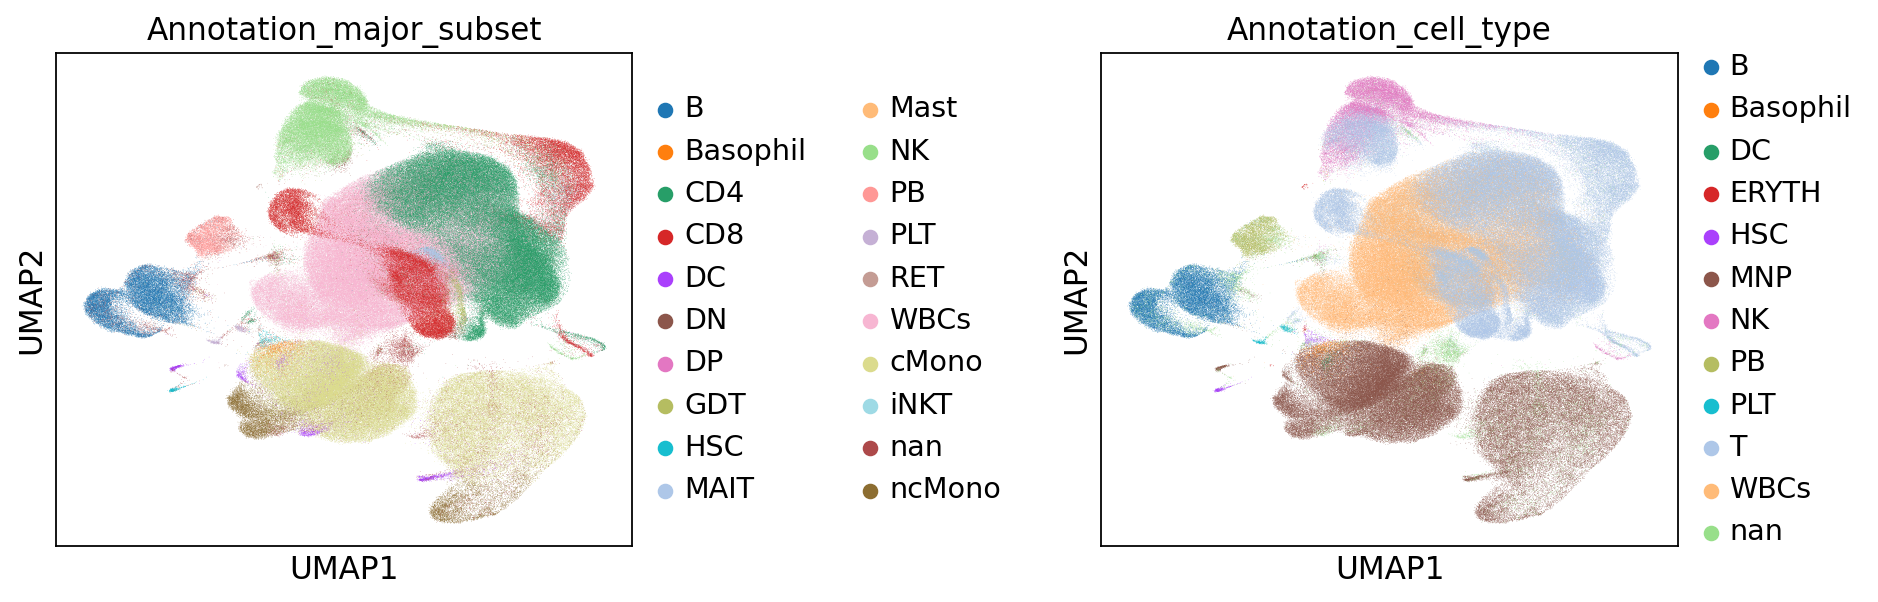

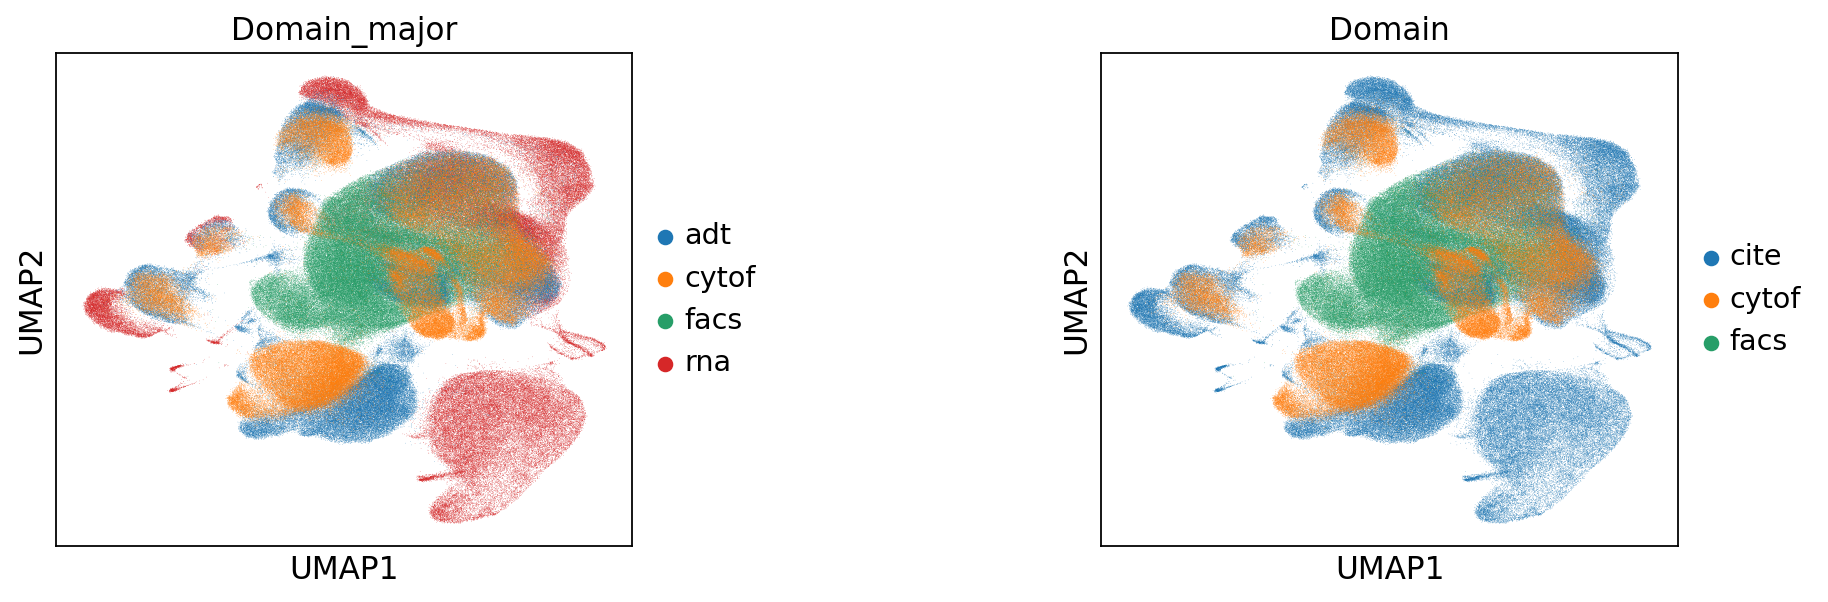

writing combined anndata with umap
combined adata with umap written successfully!

computing for integration type:  full_integration
computing for correlation type:  rna_adt_corr

loading data..
loading glue..
computing embeddings..


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


computing neighbours..
computing umap..


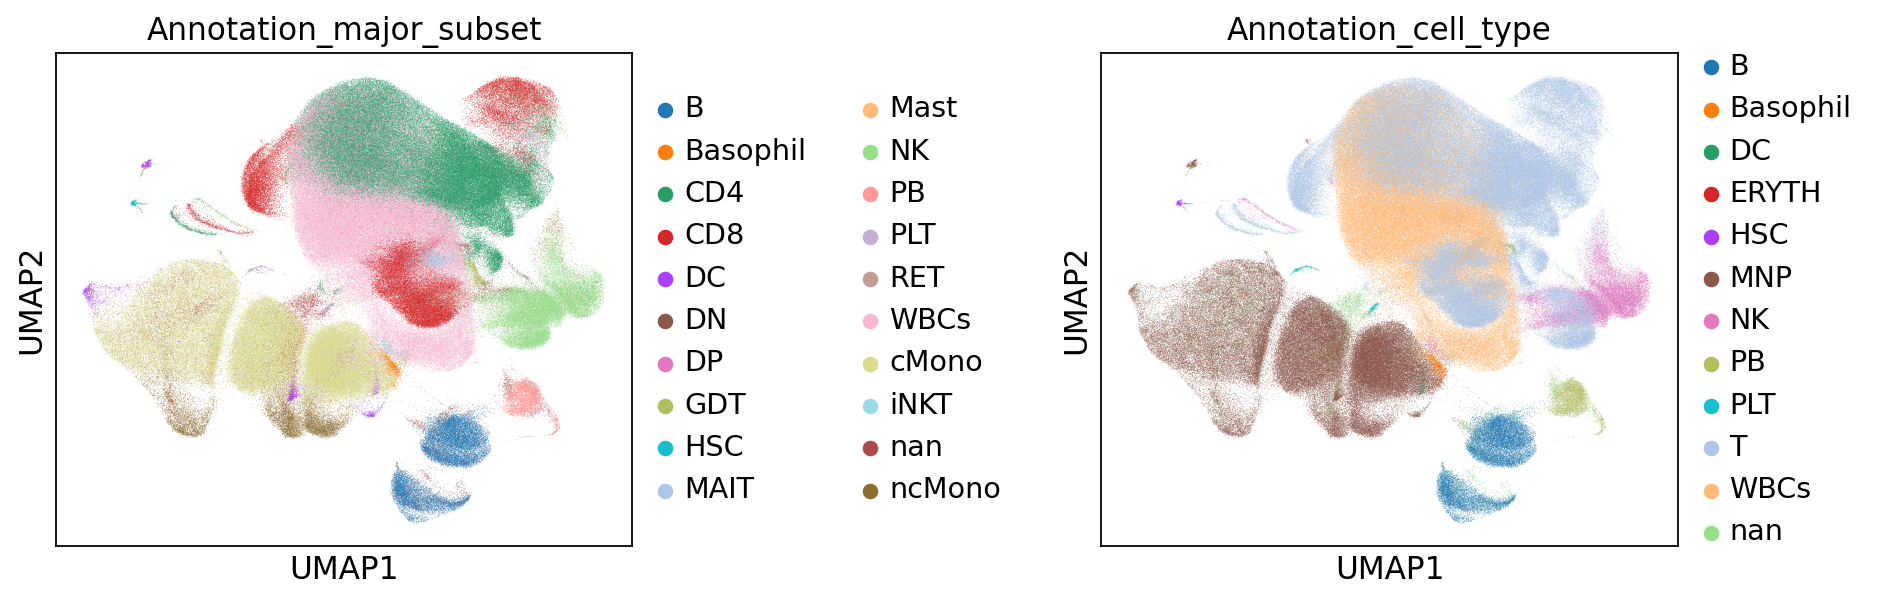

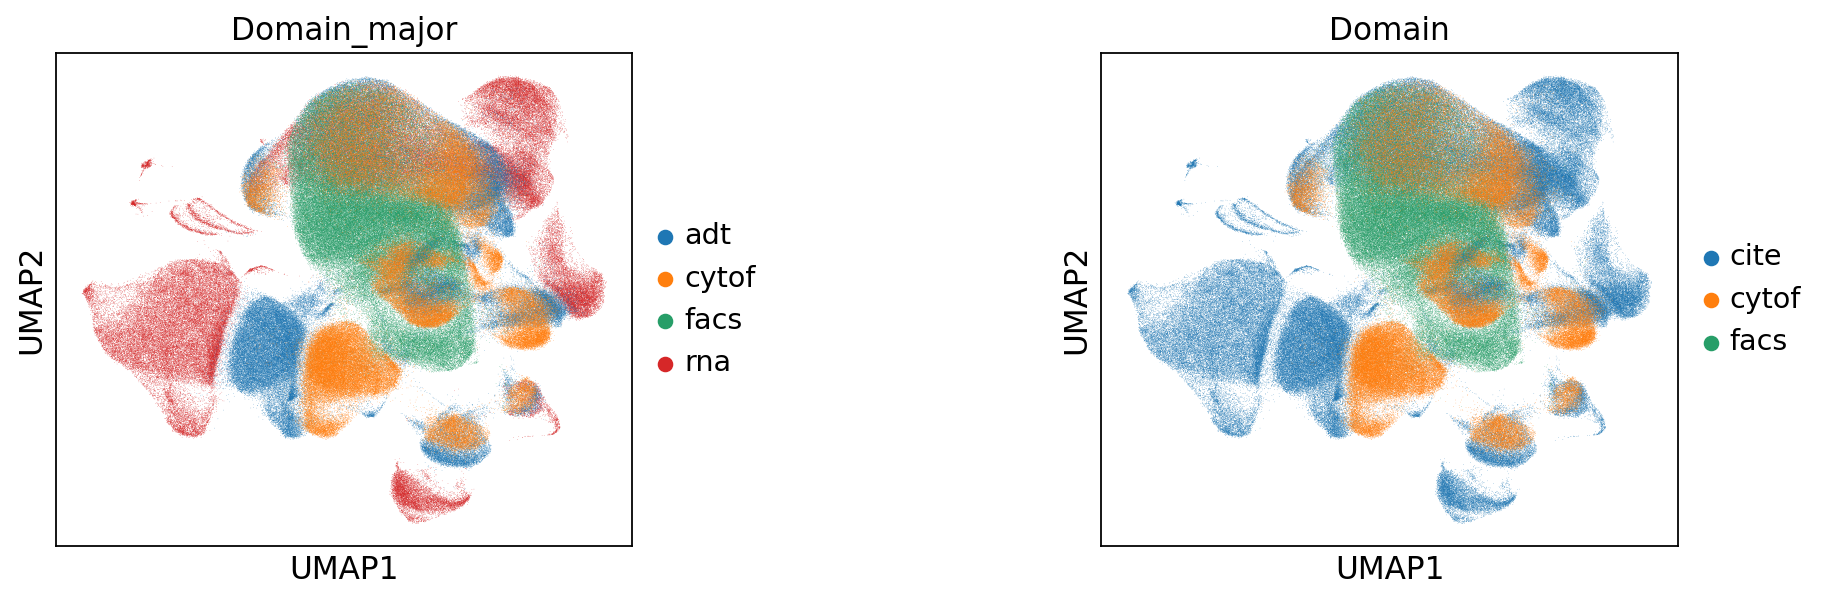

writing combined anndata with umap
combined adata with umap written successfully!

computing for integration type:  full_integration
computing for correlation type:  all_corr

loading data..
loading glue..
computing embeddings..


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


computing neighbours..
computing umap..


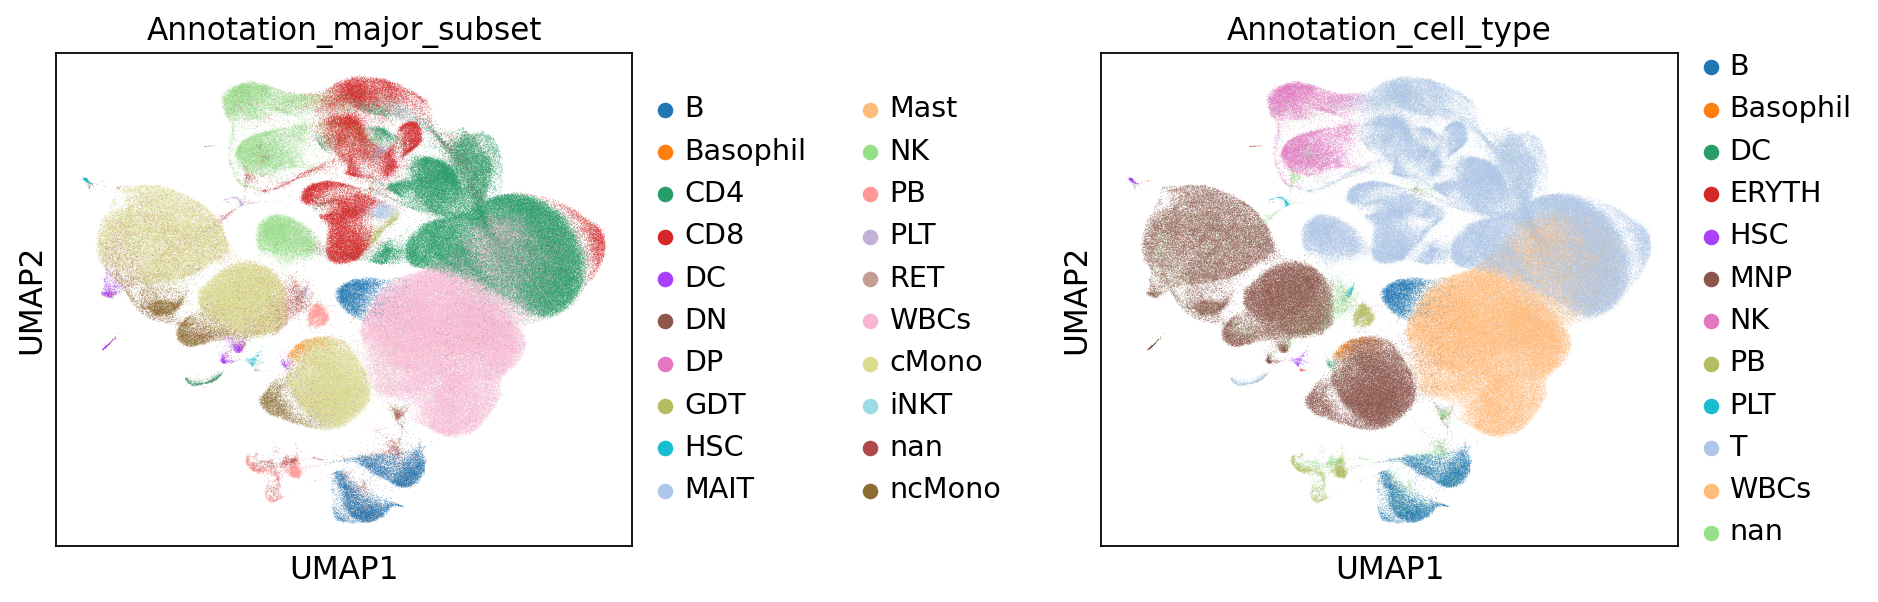

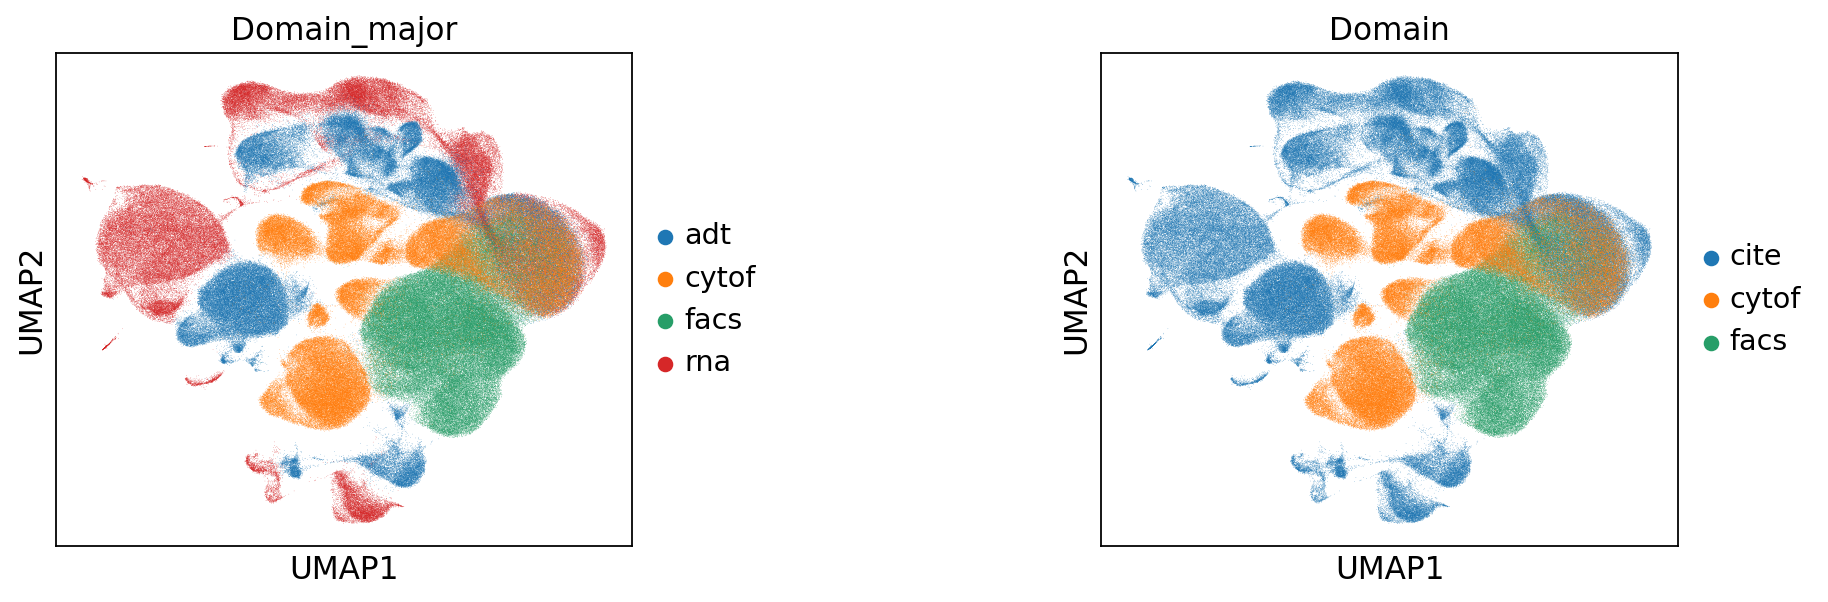

writing combined anndata with umap
combined adata with umap written successfully!


In [9]:
main() 